In [74]:
import torch
import lzma
from itertools import islice
import regex as re
import sys
from torchtext.vocab import build_vocab_from_iterator
from torch import nn
from torch.utils.data import IterableDataset
import itertools
from torch.utils.data import DataLoader

In [75]:
# torch.cuda.is_available()

In [76]:
# torch.cuda.device_count()

In [77]:
# torch.cuda.current_device()

In [78]:
# torch.cuda.device(0)

In [79]:
# torch.cuda.get_device_name(0)

In [80]:
def get_words_from_line(line):
  line = line.rstrip()
  line = re.sub(r'\\n', ' ', line)
  line = re.sub(r'[^a-zA-Z] ', ' ', line)
  line = line.lower()
  yield '<s>'
  for t in line.split():
    yield t
  yield '</s>'

def get_word_lines_from_file(file_name):
  with lzma.open(file_name, encoding='utf8', mode="rt") as fh:
    for line in fh:
      yield get_words_from_line(line)

vocab_size = 10_000

vocab = build_vocab_from_iterator(
    get_word_lines_from_file("train/in.tsv.xz"),
    max_tokens = vocab_size,
    specials = ['<unk>'])

vocab.set_default_index(vocab['<unk>'])

KeyboardInterrupt: 

In [ ]:
def look_ahead_iterator(gen):
   prev = None
   for item in gen:
      if prev is not None:
         yield (prev, item)
      prev = item

class Bigrams(IterableDataset):
  def __init__(self, text_file, vocabulary_size):
      self.vocab = vocab
      self.vocab.set_default_index(self.vocab['<unk>'])
      self.vocabulary_size = vocabulary_size
      self.text_file = text_file

  def __iter__(self):
     return look_ahead_iterator(
         (self.vocab[t] for t in itertools.chain.from_iterable(get_word_lines_from_file(self.text_file))))

train_dataset = Bigrams("train/in.tsv.xz", vocab_size)

In [ ]:
next(iter(DataLoader(train_dataset, batch_size=10)))

[tensor([  33,    0,  226,   35,    0, 6421, 6420,  219, 5781,    1]),
 tensor([   0,  226,   35,    0, 6421, 6420,  219, 5781,    1,  113])]

In [85]:
embed_size = 100

class SimpleBigramNeuralLanguageModel(nn.Module):
  def __init__(self, vocabulary_size, embedding_size):
      super(SimpleBigramNeuralLanguageModel, self).__init__()
      self.model = nn.Sequential(
          nn.Embedding(vocabulary_size, embedding_size),
          nn.Linear(embedding_size, 1000),
          nn.ReLU(),
          nn.Linear(1000, 500),
          nn.ReLU(),
          nn.Linear(500, vocabulary_size),
          nn.Softmax()
      )

  def forward(self, x):
      return self.model(x)

model = SimpleBigramNeuralLanguageModel(vocab_size, embed_size)

vocab.set_default_index(vocab['<unk>'])
ixs = torch.tensor(vocab.forward(['is']))

In [86]:
out = model(ixs)
out[0][vocab['is']]

tensor(8.4503e-05, grad_fn=<SelectBackward0>)

In [87]:
loss_track = []

device = 'cpu'
model = SimpleBigramNeuralLanguageModel(vocab_size, embed_size).to(device)
data = DataLoader(train_dataset, batch_size=6000)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.NLLLoss()

last_loss = 1_000
trigger_count = 0

model.train()
step = 0
for x, y in data:
   x = x.to(device)
   y = y.to(device)
   optimizer.zero_grad()
   ypredicted = model(x)
   loss = criterion(torch.log(ypredicted), y)
   if step % 100 == 0:
      print(step, loss)
   step += 1
   loss.backward()
   optimizer.step()

   if loss > last_loss:
      trigger_count += 1 
      print(trigger_count, 'LOSS DIFF:', loss, last_loss)

   if trigger_count >= 1_000:
      break

   loss_track.append(loss)
   last_loss = loss

0 tensor(9.2249, grad_fn=<NllLossBackward0>)
1 LOSS DIFF: tensor(6.9568, grad_fn=<NllLossBackward0>) tensor(6.9539, grad_fn=<NllLossBackward0>)
2 LOSS DIFF: tensor(6.5283, grad_fn=<NllLossBackward0>) tensor(6.3437, grad_fn=<NllLossBackward0>)
3 LOSS DIFF: tensor(6.4010, grad_fn=<NllLossBackward0>) tensor(6.3773, grad_fn=<NllLossBackward0>)
4 LOSS DIFF: tensor(6.4818, grad_fn=<NllLossBackward0>) tensor(6.4010, grad_fn=<NllLossBackward0>)
5 LOSS DIFF: tensor(6.4520, grad_fn=<NllLossBackward0>) tensor(6.3898, grad_fn=<NllLossBackward0>)
6 LOSS DIFF: tensor(6.2989, grad_fn=<NllLossBackward0>) tensor(6.2184, grad_fn=<NllLossBackward0>)
7 LOSS DIFF: tensor(6.3109, grad_fn=<NllLossBackward0>) tensor(6.2989, grad_fn=<NllLossBackward0>)
8 LOSS DIFF: tensor(6.3028, grad_fn=<NllLossBackward0>) tensor(6.2805, grad_fn=<NllLossBackward0>)
9 LOSS DIFF: tensor(6.3590, grad_fn=<NllLossBackward0>) tensor(6.3028, grad_fn=<NllLossBackward0>)
10 LOSS DIFF: tensor(6.1484, grad_fn=<NllLossBackward0>) tensor(

In [92]:
loss_track2 = [t.detach().numpy() for t in loss_track]

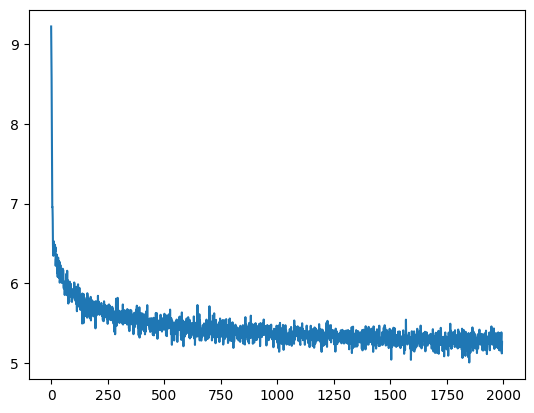

In [98]:
import matplotlib.pyplot as plt

plt.plot(loss_track2)
plt.show()

In [99]:
torch.save(model.state_dict(), 'model.bin')

In [100]:
device = 'cpu'
model = SimpleBigramNeuralLanguageModel(vocab_size, embed_size).to(device)
model.load_state_dict(torch.load('model.bin'))
model.eval()

ixs = torch.tensor(vocab.forward(['he'])).to(device)

out = model(ixs)
top = torch.topk(out[0], 10)
top_indices = top.indices.tolist()
top_probs = top.values.tolist()
top_words = vocab.lookup_tokens(top_indices)
list(zip(top_words, top_indices, top_probs))

c:\PROGRAMY\Anaconda3\envs\scweet\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[('<unk>', 0, 0.1108938604593277),
 ('was', 12, 0.0792110487818718),
 ('had', 37, 0.07402306795120239),
 ('is', 8, 0.04529397189617157),
 ('has', 39, 0.03909718990325928),
 ('would', 48, 0.038855526596307755),
 ('said', 43, 0.022579118609428406),
 ('will', 27, 0.02008220925927162),
 ('went', 251, 0.013605386018753052),
 ('did', 151, 0.013007525354623795)]

In [101]:
def prediction(word: str) -> str:
    ixs = torch.tensor(vocab.forward([word])).to(device)
    out = model(ixs)
    top = torch.topk(out[0], 5)
    top_indices = top.indices.tolist()
    top_probs = top.values.tolist()
    top_words = vocab.lookup_tokens(top_indices)
    zipped = list(zip(top_words, top_probs))
    for index, element in enumerate(zipped):
        unk = None
        if '<unk>' in element:
            unk = zipped.pop(index)
            zipped.append(('', unk[1]))
            break
    if unk is None:
        zipped[-1] = ('', zipped[-1][1])
    return ' '.join([f'{x[0]}:{x[1]}' for x in zipped])

In [102]:
def create_outputs(folder_name):
    print(f'Creating outputs in {folder_name}')
    with lzma.open(f'{folder_name}/in.tsv.xz', mode='rt', encoding='utf-8') as fid:
        with open(f'{folder_name}/out.tsv', 'w', encoding='utf-8', newline='\n') as f:
            for line in fid:
                separated = line.split('\t')
                prefix = separated[6].replace(r'\n', ' ').split()[-1]
                output_line = prediction(prefix)
                f.write(output_line + '\n')

In [103]:
create_outputs('dev-0')
create_outputs('test-A')

Creating outputs in dev-0
Creating outputs in test-A
